# Imports

In [78]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import numpy as np

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# Load Data

In [79]:
data = pd.read_csv("data/data_cleaned.csv")

# Data Preparation

In [80]:
# one hot
data = pd.get_dummies(data, prefix = ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"], columns = ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"])

In [81]:
# split
x_data = data.drop(["PRICE"], axis=1)
y_data = data["PRICE"]

In [82]:
# normalization
x_data = x_data.astype(float)
x_data = x_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [83]:
# train & test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

# NN

In [84]:
model = Sequential()
model.add(Dense(512, activation="tanh", kernel_initializer='normal', input_shape=(252,)))

model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.05), bias_regularizer=regularizers.l1(0.05)))
model.add(Dropout(0.7))
model.add(Dense(128, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.05), bias_regularizer=regularizers.l1_l2(0.05)))
model.add(Dropout(0.6))
model.add(Dense(128, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=["mae"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               129536    
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_38 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
__________

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit(x_train, 
          y_train,
          batch_size = 128,
          shuffle = True,
          epochs = 40,
          validation_data = (x_test, y_test),
          callbacks=[es])

Train on 52058 samples, validate on 25641 samples
Epoch 1/40
52058/52058 [==============================] - 21s 413us/step - loss: 309456780896.2471 - mean_absolute_error: 243639.4014 - val_loss: 227143670495.1426 - val_mean_absolute_error: 178908.2471
Epoch 2/40
52058/52058 [==============================] - 20s 377us/step - loss: 243634237550.6261 - mean_absolute_error: 201870.1510 - val_loss: 212760929480.1195 - val_mean_absolute_error: 178208.0806
Epoch 3/40
52058/52058 [==============================] - 21s 408us/step - loss: 228310478194.7864 - mean_absolute_error: 200129.5042 - val_loss: 202853686011.1777 - val_mean_absolute_error: 176286.3604
Epoch 4/40
52058/52058 [==============================] - 23s 450us/step - loss: 223653888023.6044 - mean_absolute_error: 199229.9658 - val_loss: 200634322461.4927 - val_mean_absolute_error: 173592.5107
Epoch 5/40
52058/52058 [==============================] - 20s 376us/step - loss: 214501834053.6233 - mean_absolute_error: 196384.9447 - va

In [86]:
train_score = model.evaluate(x_train, y_train, verbose=0)
valid_score = model.evaluate(x_test, y_test, verbose=0)

y_pred = model.predict(x_test)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  158008.2309 , Train Loss:  155476575466.0
Val MAE:  162226.5507 , Val Loss:  169686603685.0


In [87]:
model.evaluate(x_test, y_test, batch_size=16)

25641/25641 [==============================] - 8s 322us/step


[169686604575.71921, 162226.55067689443]

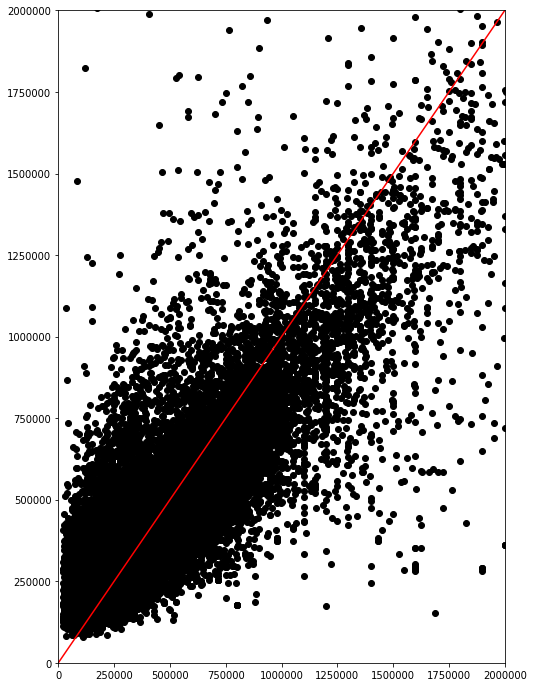

In [88]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
plt.xlim(0, 2000000)
plt.ylim(0, 2000000)
ax.add_line(line)
plt.show()

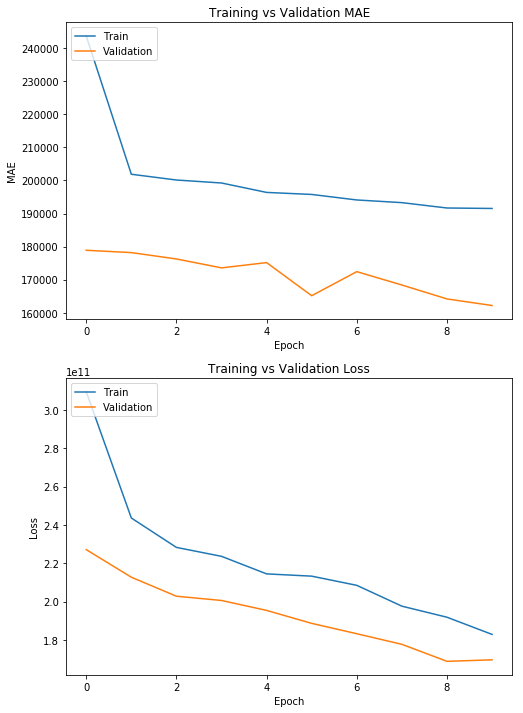

In [89]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)